In [1]:
# !pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
# !pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
import sys
# sys.path.insert(0, "../input/timm-efficientdet-pytorch")
# sys.path.insert(0, "../input/omegaconf")
# sys.path.insert(0, "../input/weightedboxesfusion")

import time
from tqdm.notebook import tqdm
from ast import literal_eval
import torch
import numba
from numba import jit
from typing import List, Union, Tuple
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
import seaborn as sns
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet

In [3]:
@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [4]:
box1 = np.array([1.0, 1.0, 10.0, 10.0])
box2 = np.array([2.0, 1.0, 10.0, 10.0])

calculate_iou(box1, box2, form='pascal_voc')

0.9

In [5]:
import numpy as np

def bb_intersection_over_union(A, B):
    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    if interArea == 0:
        return 0.0

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (A[2] - A[0]) * (A[3] - A[1])
    boxBArea = (B[2] - B[0]) * (B[3] - B[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def prefilter_boxes(boxes, scores, labels, weights, thr):
    # Create dict with boxes stored by its label
    new_boxes = dict()
    for t in range(len(boxes)):
        for j in range(len(boxes[t])):
            label = int(labels[t][j])
            score = scores[t][j]
            if score < thr:
                break
            box_part = boxes[t][j]
            b = [int(label), float(score) * weights[t], float(box_part[0]), float(box_part[1]), float(box_part[2]), float(box_part[3])]
            if label not in new_boxes:
                new_boxes[label] = []
            new_boxes[label].append(b)

    # Sort each list in dict and transform it to numpy array
    for k in new_boxes:
        current_boxes = np.array(new_boxes[k])
        new_boxes[k] = current_boxes[current_boxes[:, 1].argsort()[::-1]]

    return new_boxes


def get_weighted_box(boxes, conf_type='avg'):
    """
    Create weighted box for set of boxes
    :param boxes: set of boxes to fuse 
    :param conf_type: type of confidence one of 'avg' or 'max'
    :return: weighted box
    """

    box = np.zeros(6, dtype=np.float32)
    conf = 0
    conf_list = []
    for b in boxes:
        box[2:] += (b[1] * b[2:])
        conf += b[1]
        conf_list.append(b[1])
    box[0] = boxes[0][0]
    if conf_type == 'avg':
        box[1] = conf / len(boxes)
    elif conf_type == 'max':
        box[1] = np.array(conf_list).max()
    box[2:] /= conf
    return box


def find_matching_box(boxes_list, new_box, match_iou):
    best_iou = match_iou
    best_index = -1
    for i in range(len(boxes_list)):
        box = boxes_list[i]
        if box[0] != new_box[0]:
            continue
        iou = bb_intersection_over_union(box[2:], new_box[2:])
        if iou > best_iou:
            best_index = i
            best_iou = iou

    return best_index, best_iou


def weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=None, iou_thr=0.55, skip_box_thr=0.0, conf_type='avg', allows_overflow=False):
    '''
    :param boxes_list: list of boxes predictions from each model, each box is 4 numbers. 
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1]
    :param scores_list: list of scores for each model 
    :param labels_list: list of labels for each model
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model
    :param intersection_thr: IoU value for boxes to be a match
    :param skip_box_thr: exclude boxes with score lower than this variable  
    :param conf_type: how to calculate confidence in weighted boxes. 'avg': average value, 'max': maximum value
    :param allows_overflow: false if we want confidence score not exceed 1.0 
    
    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2). 
    :return: scores: confidence scores
    :return: labels: boxes labels
    '''

    if weights is None:
        weights = np.ones(len(boxes_list))
    if len(weights) != len(boxes_list):
        print('Warning: incorrect number of weights {}. Must be: {}. Set weights equal to 1.'.format(len(weights), len(boxes_list)))
        weights = np.ones(len(boxes_list))
    weights = np.array(weights)

    if conf_type not in ['avg', 'max']:
        print('Unknown conf_type: {}. Must be "avg" or "max"'.format(conf_type))
        exit()

    filtered_boxes = prefilter_boxes(boxes_list, scores_list, labels_list, weights, skip_box_thr)
    if len(filtered_boxes) == 0:
        return np.zeros((0, 4)), np.zeros((0,)), np.zeros((0,))

    overall_boxes = []
    for label in filtered_boxes:
        boxes = filtered_boxes[label]
        new_boxes = []
        weighted_boxes = []

        # Clusterize boxes
        for j in range(0, len(boxes)):
            index, best_iou = find_matching_box(weighted_boxes, boxes[j], iou_thr)
            if index != -1:
                new_boxes[index].append(boxes[j])
                weighted_boxes[index] = get_weighted_box(new_boxes[index], conf_type)
            else:
                new_boxes.append([boxes[j].copy()])
                weighted_boxes.append(boxes[j].copy())

        # Rescale confidence based on number of models and boxes
        for i in range(len(new_boxes)):
            if not allows_overflow:
                weighted_boxes[i][1] = weighted_boxes[i][1] * min(weights.sum(), len(new_boxes[i])) / weights.sum()
            else:
                weighted_boxes[i][1] = weighted_boxes[i][1] * len(new_boxes[i]) / weights.sum()
        overall_boxes.append(np.array(weighted_boxes))

    overall_boxes = np.concatenate(overall_boxes, axis=0)
    overall_boxes = overall_boxes[overall_boxes[:, 1].argsort()[::-1]]
    boxes = overall_boxes[:, 2:]
    scores = overall_boxes[:, 1]
    labels = overall_boxes[:, 0]
    return boxes, scores, labels

In [6]:
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [7]:
line_df = pd.read_csv("../input/line-detection-iam/forms.csv")
line_df["full_bb"] = line_df.full_bb.apply(lambda x: literal_eval(x))
line_df["line_bb"] = line_df.line_bb.apply(lambda x: literal_eval(x))
line_df_train = line_df[line_df["fold"] != 0]
TRAIN_ROOT_PATH = '../input/line-detection-iam/dataset/images/train'

line_marking_train = []
z = 0
for row in tqdm(line_df_train.values):
    image_id = row[0]
    
    path = f'{TRAIN_ROOT_PATH}/{image_id}.jpg'
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    
    f = open(path.replace('images', 'labels').replace('jpg', 'txt'), 'r')
    bbs = f.readlines()
    bbs = np.array([[float(b) for b in bb.split(' ')] for bb in bbs])[:, 1:]
    
    bbs[:, 0] = bbs[:, 0] * image.shape[1]
    bbs[:, 1] = bbs[:, 1] * image.shape[0]
    bbs[:, 2] = bbs[:, 2] * image.shape[1]
    bbs[:, 3] = bbs[:, 3] * image.shape[0]
    bbs[:, 0] = bbs[:, 0] - (bbs[:, 2] / 2)
    bbs[:, 1] = bbs[:, 1] - (bbs[:, 3] / 2)
    bbs = bbs.astype(np.int32)
    bbs[:, 0] = np.clip(bbs[:, 0], 0, image.shape[1])
    bbs[:, 1] = np.clip(bbs[:, 1], 0, image.shape[0])
    bbs[:, 2] = np.clip(bbs[:, 2], 0, image.shape[1])
    bbs[:, 3] = np.clip(bbs[:, 3], 0, image.shape[0])
    
    f.close()
    bbs = [bb.tolist() for bb in bbs]
    
    final = np.concatenate([np.array([[image_id]] * len(bbs)), bbs], axis=1).tolist()
    line_marking_train += final
    
    z += 1
    if z == 100:
        pass

line_marking_train = np.array(line_marking_train)
line_marking_train = pd.DataFrame(line_marking_train, columns=['image_id', 'x', 'y', 'w', 'h'])
line_marking_train

image_id   x     y     w    h
0      m01-115  80     0  1621  106
1      m01-115  69   162  1814  155
2      m01-115   0   314  1862  175
3      m01-115  71   500  1907  144
4      m01-115  84   671  1955  151
...        ...  ..   ...   ...  ...
10678  e07-061  19  1079  1761   95
10679  e07-061  20  1249  1812  113
10680  e07-061  18  1437  1789   93
10681  e07-061  24  1613  1787  107
10682  e07-061  27  1781  1157  117

[10683 rows x 5 columns]

In [8]:
line_df = pd.read_csv("../input/line-detection-iam/forms.csv")
line_df["full_bb"] = line_df.full_bb.apply(lambda x: literal_eval(x))
line_df["line_bb"] = line_df.line_bb.apply(lambda x: literal_eval(x))
line_df_valid = line_df[line_df["fold"] == 0]
VALID_ROOT_PATH = '../input/line-detection-iam/dataset/images/valid'

line_marking_valid = []
z = 0
for row in tqdm(line_df_valid.values):
    image_id = row[0]
    
    path = f'{VALID_ROOT_PATH}/{image_id}.jpg'
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    
    f = open(path.replace('images', 'labels').replace('jpg', 'txt'), 'r')
    bbs = f.readlines()
    bbs = np.array([[float(b) for b in bb.split(' ')] for bb in bbs])[:, 1:]
    
    bbs[:, 0] = bbs[:, 0] * image.shape[1]
    bbs[:, 1] = bbs[:, 1] * image.shape[0]
    bbs[:, 2] = bbs[:, 2] * image.shape[1]
    bbs[:, 3] = bbs[:, 3] * image.shape[0]
    bbs[:, 0] = bbs[:, 0] - (bbs[:, 2] / 2)
    bbs[:, 1] = bbs[:, 1] - (bbs[:, 3] / 2)
    bbs = bbs.astype(np.int32)
    bbs[:, 0] = np.clip(bbs[:, 0], 0, image.shape[1])
    bbs[:, 1] = np.clip(bbs[:, 1], 0, image.shape[0])
    bbs[:, 2] = np.clip(bbs[:, 2], 0, image.shape[1])
    bbs[:, 3] = np.clip(bbs[:, 3], 0, image.shape[0])
    
    f.close()
    bbs = [bb.tolist() for bb in bbs]
    
    final = np.concatenate([np.array([[image_id]] * len(bbs)), bbs], axis=1).tolist()
    line_marking_valid += final

line_marking_valid = np.array(line_marking_valid)
line_marking_valid = pd.DataFrame(line_marking_valid, columns=['image_id', 'x', 'y', 'w', 'h'])
line_marking_valid

image_id   x     y     w   h
0     e07-098  10     0  1672  76
1     e07-098   9   180  1540  72
2     e07-098  13   351  1755  97
3     e07-098  21   533  1694  87
4     e07-098  14   700  1521  96
...       ...  ..   ...   ...  ..
2665  e07-000  33   375  1586  68
2666  e07-000  17   555  1793  73
2667  e07-000   1   732  1842  82
2668  e07-000   7   906  1799  88
2669  e07-000   0  1095   459  73

[2670 rows x 5 columns]

In [9]:
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.0:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        if self.test:
            image = cv2.imread(f'{VALID_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        else:
            image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values.astype(np.int32)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b
            
            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [10]:
np.unique(line_marking_train.image_id.values)

array(['a01-000u', 'a01-000x', 'a01-003', ..., 'r06-130', 'r06-137',
       'r06-143'], dtype=object)

In [11]:
DATA_ROOT_PATH = '../input/line-detection-iam/dataset/images/train'
dataset = DatasetRetriever(
    image_ids=np.unique(line_marking_train.image_id.values),
    marking=line_marking_train,
    transforms=get_valid_transforms(),
    test=False
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [12]:
VALID_ROOT_PATH = '../input/line-detection-iam/dataset/images/valid'
valid_dataset = DatasetRetriever(
    image_ids=np.unique(line_marking_valid.image_id.values),
    marking=line_marking_valid,
    transforms=get_valid_transforms(),
    test=True,
)

def collate_fn(batch):
    return tuple(zip(*batch))

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [13]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

net = load_net('../input/efficientdetworking/effdet5-cutmix-augmix/EfficientDet-004-epoch.bin')

In [14]:
def make_predictions(images, score_threshold=0.22):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

/opt/conda/conda-bld/pytorch_1587428398394/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.



0.7613410814788893
0.19122807017543855 0.9868421052631575


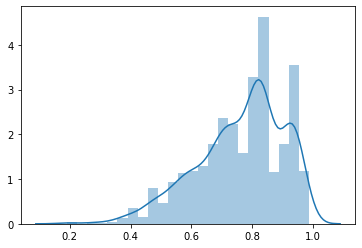

In [15]:
import random
import matplotlib.pyplot as plt
train_precisions = []

for k in tqdm(range(len(dataset))):
    images, target, image_ids = dataset[k]
    images_1, target, image_ids_1 = dataset[k]

    images = [images, images_1]
    image_ids = [image_ids, image_ids_1]

    predictions = make_predictions(images, score_threshold=0.1)

    i = 0
    sample = images[i].permute(1,2,0).cpu().numpy()

    boxes, scores, labels = run_wbf(predictions, image_index=i)
    boxes = boxes.astype(np.int32).clip(min=0, max=511)

    target['boxes'] = target['boxes'].numpy().astype(np.int32)
    t = target['boxes'][:, 0].copy()
    target['boxes'][:, 0] = target['boxes'][:, 1].copy()
    target['boxes'][:, 1] = t
    t = target['boxes'][:, 2].copy()
    target['boxes'][:, 2] = target['boxes'][:, 3].copy()
    target['boxes'][:, 3] = t

    preds_sorted_idx = np.argsort(scores)[::-1]
    boxes = boxes[preds_sorted_idx]

    iou_thresholds = numba.typed.List()
    for x in [0.5, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
        iou_thresholds.append(x)
    image_precision = calculate_image_precision(target['boxes'], boxes,
                                                thresholds=iou_thresholds,
                                                form='pascal_voc')
    train_precisions.append(image_precision)
#     print(image_precision)

print(sum(train_precisions) / len(train_precisions))
print(min(train_precisions), max(train_precisions))
sns.distplot(train_precisions)


0.7243013572913362
0.15789473684210525 0.964912280701754


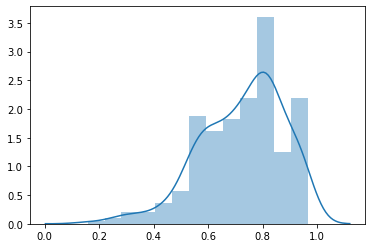

In [16]:
import random
import matplotlib.pyplot as plt
train_precisions = []

for k in tqdm(range(len(valid_dataset))):    
    images, target, image_ids = valid_dataset[k]
    images_1, target, image_ids_1 = valid_dataset[k]

    images = [images, images_1]
    image_ids = [image_ids, image_ids_1]

    predictions = make_predictions(images, score_threshold=0.1)

    i = 0
    sample = images[i].permute(1,2,0).cpu().numpy()

    boxes, scores, labels = run_wbf(predictions, image_index=i)
    boxes = boxes.astype(np.int32).clip(min=0, max=511)

    target['boxes'] = target['boxes'].numpy().astype(np.int32)
    t = target['boxes'][:, 0].copy()
    target['boxes'][:, 0] = target['boxes'][:, 1].copy()
    target['boxes'][:, 1] = t
    t = target['boxes'][:, 2].copy()
    target['boxes'][:, 2] = target['boxes'][:, 3].copy()
    target['boxes'][:, 3] = t

    preds_sorted_idx = np.argsort(scores)[::-1]
    boxes = boxes[preds_sorted_idx]

    iou_thresholds = numba.typed.List()
    for x in [0.5, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
        iou_thresholds.append(x)
    image_precision = calculate_image_precision(target['boxes'], boxes,
                                                thresholds=iou_thresholds,
                                                form='pascal_voc')
    train_precisions.append(image_precision)
#     print(image_precision)

print(sum(train_precisions) / len(train_precisions))
print(min(train_precisions), max(train_precisions))
sns.distplot(train_precisions)

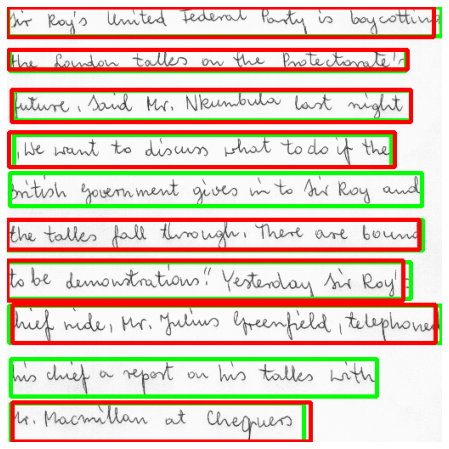

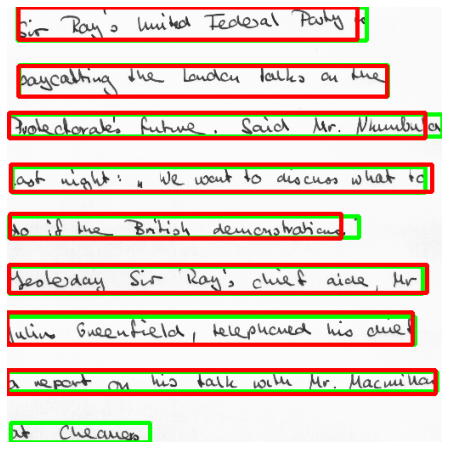

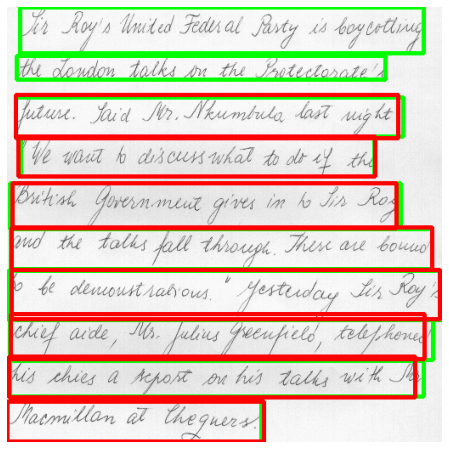

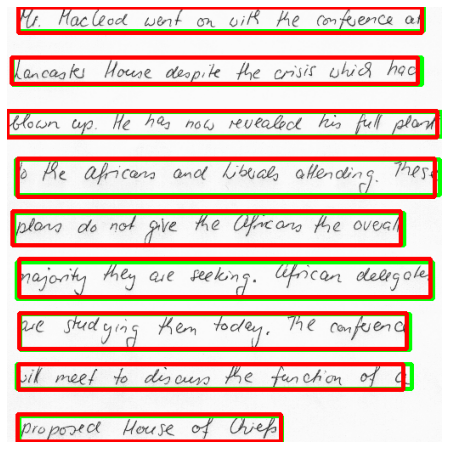

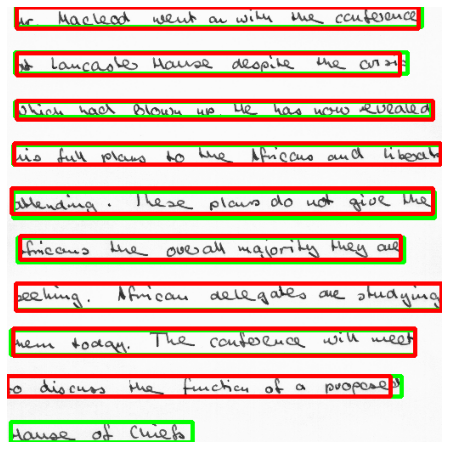

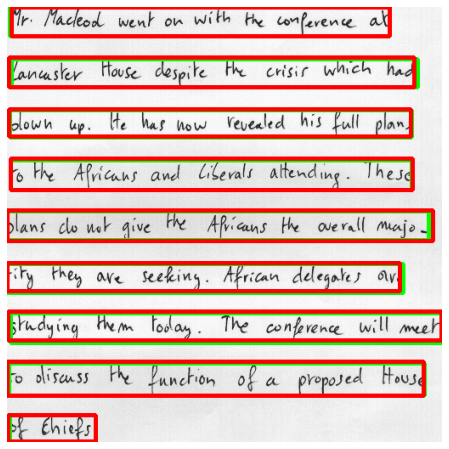

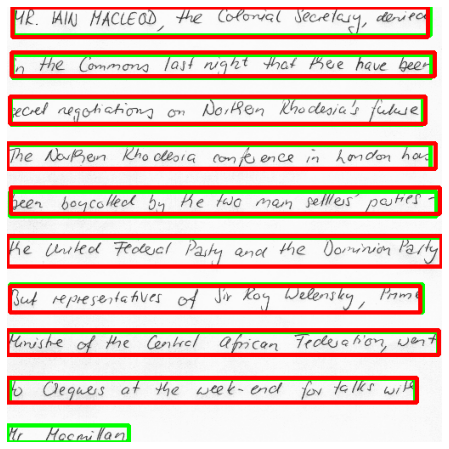

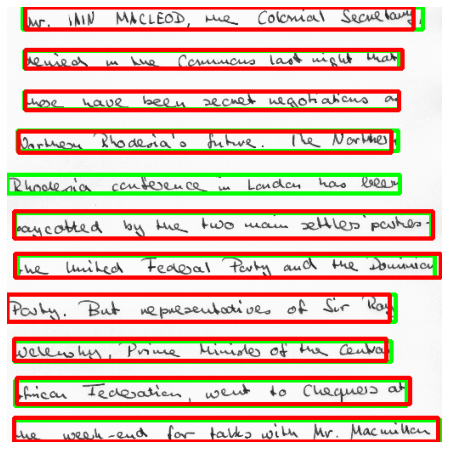

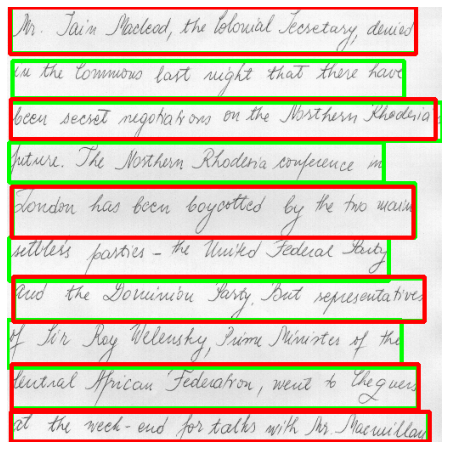

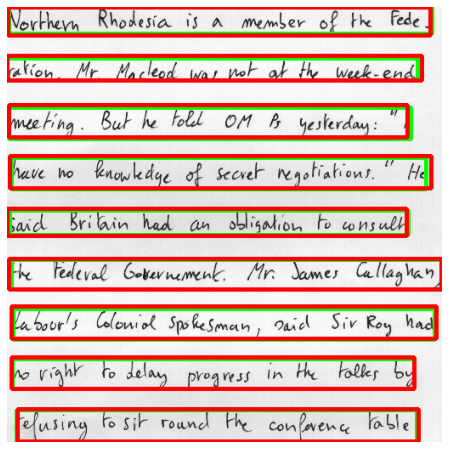

In [17]:
import random
import matplotlib.pyplot as plt

for k in range(10, 20):
    images, target, image_ids = dataset[k]
    images_1, target, image_ids_1 = dataset[k]
    
#     images, target, image_ids = valid_dataset[k]
#     images_1, target, image_ids_1 = valid_dataset[k]

    images = [images, images_1]
    image_ids = [image_ids, image_ids_1]

    predictions = make_predictions(images, score_threshold=0.1)

    i = 0
    sample = images[i].permute(1,2,0).cpu().numpy()

    boxes, scores, labels = run_wbf(predictions, image_index=i)
    boxes = boxes.astype(np.int32).clip(min=0, max=511)

    target['boxes'] = target['boxes'].numpy().astype(np.int32)
    t = target['boxes'][:, 0].copy()
    target['boxes'][:, 0] = target['boxes'][:, 1].copy()
    target['boxes'][:, 1] = t
    t = target['boxes'][:, 2].copy()
    target['boxes'][:, 2] = target['boxes'][:, 3].copy()
    target['boxes'][:, 3] = t

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in target['boxes']:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 1, 0), 3)

    for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 3)
    preds_sorted_idx = np.argsort(scores)[::-1]
    boxes = boxes[preds_sorted_idx]

    iou_thresholds = numba.typed.List()
    for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
        iou_thresholds.append(x)
    image_precision = calculate_image_precision(target['boxes'], boxes,
                                                thresholds=iou_thresholds,
                                                form='pascal_voc')

    ax.set_axis_off()
    ax.imshow(sample);

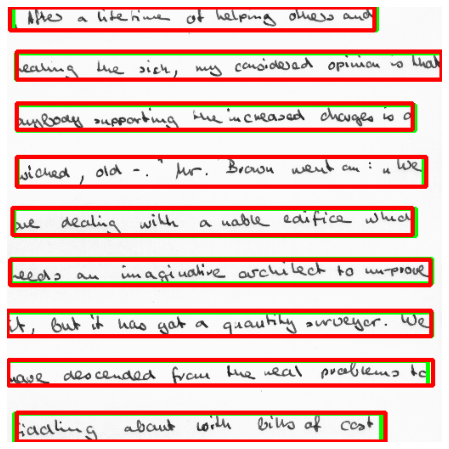

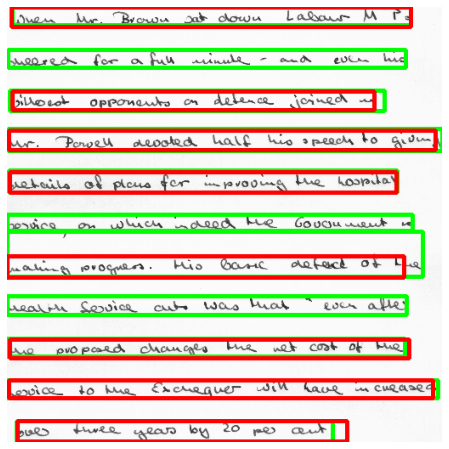

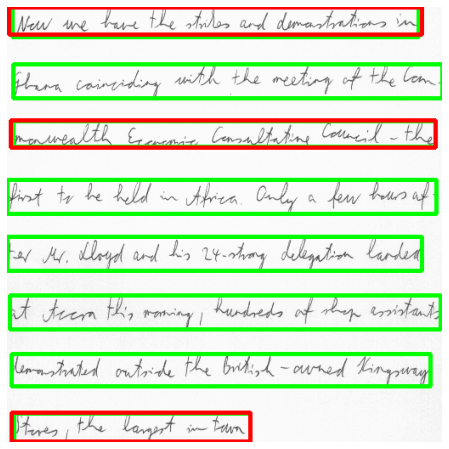

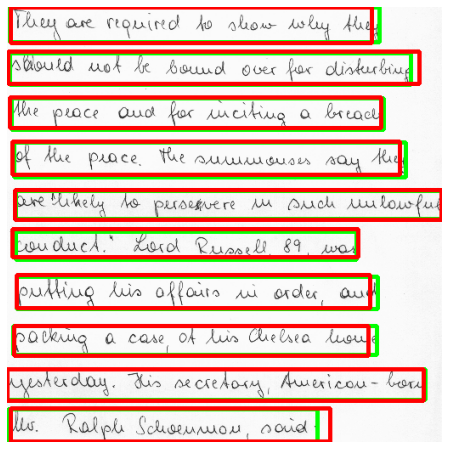

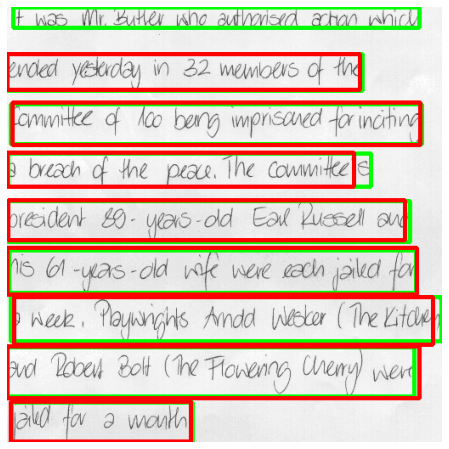

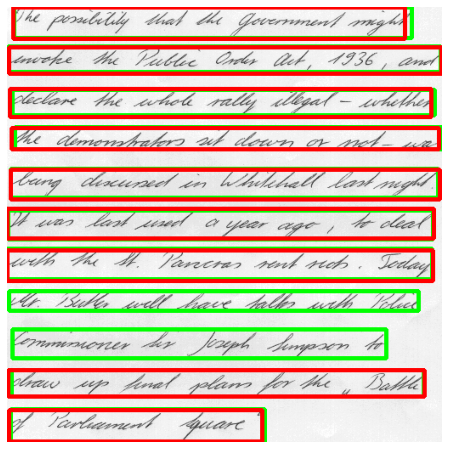

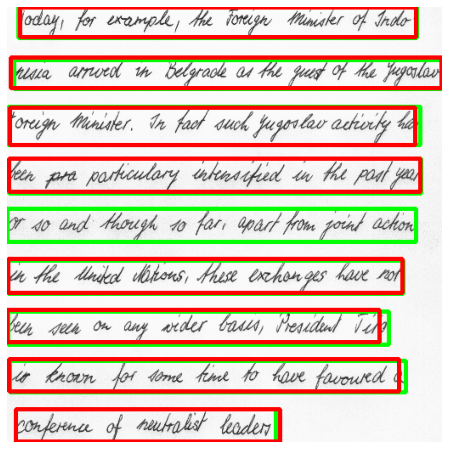

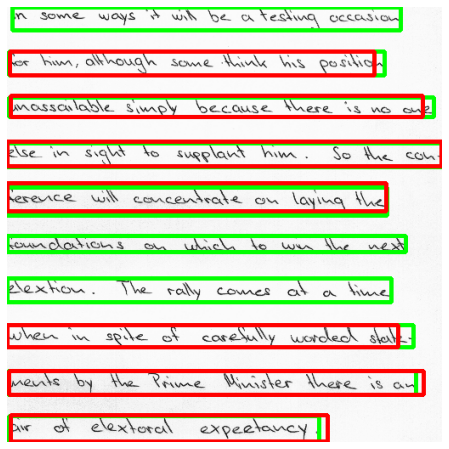

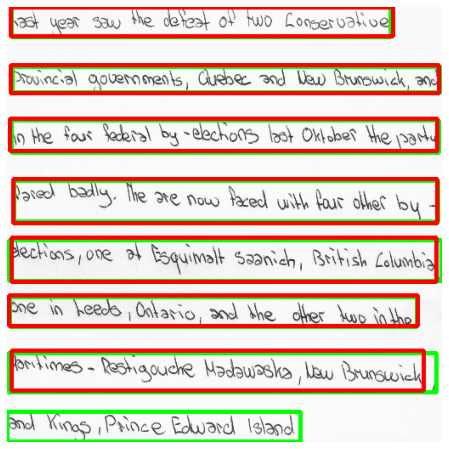

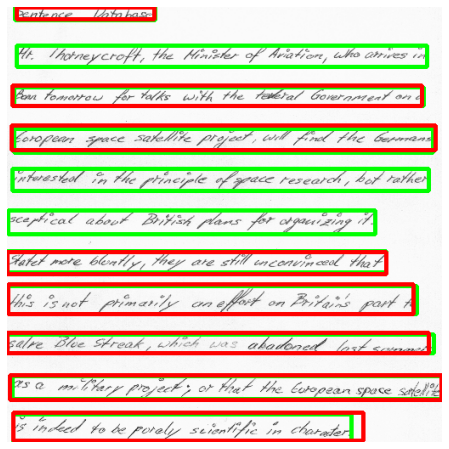

In [18]:
import random
import matplotlib.pyplot as plt

for k in range(10, 20):
#     images, target, image_ids = dataset[k]
#     images_1, target, image_ids_1 = dataset[k]
    
    images, target, image_ids = valid_dataset[k]
    images_1, target, image_ids_1 = valid_dataset[k]

    images = [images, images_1]
    image_ids = [image_ids, image_ids_1]

    predictions = make_predictions(images, score_threshold=0.1)

    i = 0
    sample = images[i].permute(1,2,0).cpu().numpy()

    boxes, scores, labels = run_wbf(predictions, image_index=i)
    boxes = boxes.astype(np.int32).clip(min=0, max=511)

    target['boxes'] = target['boxes'].numpy().astype(np.int32)
    t = target['boxes'][:, 0].copy()
    target['boxes'][:, 0] = target['boxes'][:, 1].copy()
    target['boxes'][:, 1] = t
    t = target['boxes'][:, 2].copy()
    target['boxes'][:, 2] = target['boxes'][:, 3].copy()
    target['boxes'][:, 3] = t

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in target['boxes']:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 1, 0), 3)

    for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 3)
    preds_sorted_idx = np.argsort(scores)[::-1]
    boxes = boxes[preds_sorted_idx]

    iou_thresholds = numba.typed.List()
    for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
        iou_thresholds.append(x)
    image_precision = calculate_image_precision(target['boxes'], boxes,
                                                thresholds=iou_thresholds,
                                                form='pascal_voc')

    ax.set_axis_off()
    ax.imshow(sample);